In [1]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [ ]:
!ls

In [3]:
%cd Dipole_Manuscript_elements/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Dipole_Manuscript_elements


In [4]:
!ls

Dipole_01.py                     Vel_Dist_init_Uniform06
Dipole_01.pyc                    Vel_Dist_init_Uniform07
Dipole_Manuscript_elements       Vel_Dist_init_Uniform08
Test1.py                         Vel_Dist_init_Uniform09
Vel_Dist_init_Uniform            Vel_Dist_init_Uniform10
Vel_Dist_init_Uniform02          Vel_Dist_init_Uniform11
Vel_Dist_init_Uniform03          Vel_Dist_init_Uniform12
Vel_Dist_init_Uniform04          Vel_Dist_init_Uniform13
Vel_Dist_init_Uniform05          Velocity_Ensamble_01_Img0000.png


In [2]:
# coding: utf-8
import numpy as np
from matplotlib import pyplot as plt
def orto(x):
    if np.dot(x,x) == 0:
        return 'No se puede: ese es el vector cero!'
    else:
        if 0 not in x:
            v1 = 1
            v2 = -(x[0]/x[1])
            v3 = 0
            #return np.array([v1,v2,v3])
        else:
            if x[0] == 0:
                if x[1] == 0:
                    v1 = 1
                    v2 = 0
                    v3 = 0
                else:
                    v1 = 0
                    v2 = 0
                    v3 = 1
            elif x[1] == 0:
                v1 = 0
                v2 = 1
                v3 = 0
            else:
                v1 = 0
                v2 = 0
                v3 = 1
        return np.array([v1,v2,v3])
    
#Funcion que regresa dos vectores; numpy arrays de 3D, ortogonales al vector de input x.
#Esto es, devuelven la base al espacio ortogonal definido por el vector x de entrada.
#@jit
def base_ort_nor(x):
    y = orto(x)
    v1 = y/np.linalg.norm(y)
    z = np.cross(x,v1)
    v2 = z/np.linalg.norm(z)
    return v1, v2


#Esta funcion genera un vector con distrubucion uniforme en las direcciones sobre un plano tangente a la esfera de radio R.
#@jit
def vector_des(v1,v2):
    na = 2*np.pi*np.random.rand()
    vn = v1*np.cos(na) + v2*np.sin(na)
    return vn/np.linalg.norm(vn)

R = 1

#Normalizamos al vector de desplazamiento para que intersecte al vector de la nueva posicion de acuerdo con que el
#desplazamiento (s) sobre la esfera, sobre este arco de circulo maximo, sea el determinado por el movimiento browniano particular.
#@jit
def vector_q(x,s):
    q = (R)*np.tan(s/(R))
    return q*x

#Dados todos los datos anteriores, esta funcion actualiza la posicion de la particula.
#Lo que hace es que la mueve sobre el plano tangente a la esfera en la direccion predeterminada de tal suerte que el desplazamiento efectivo
#s sobre una geodesica de la esfera, se el deseado, y posteriormente la proyecta sobre la superficie de la esfera.
#@jit
def nuevo_r(r, vector_q):
    y = r + vector_q
    y = y/np.linalg.norm(y)
    return (R)*y

#funcion que incorpora el efecto de un campo externo

def nuevo_r_field(r, vector_q, field):
    y = r + vector_q + field
    y = y/np.linalg.norm(y)
    return y


def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    field = -v0*np.cos(2*theta)*theta_uni(theta, phi)
    return field


#Esta funcion ensambla todo lo anterior: como imput necesita una posicion inicial y un arco de desplazamiento
#Como output da un vector de posicion nuevo dada un tipo de desplazamiento.
#@jit
def actualiza(r,s):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r(r, q)

def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))


#Esta funcion actualiza la posicion de todos los elementos de una lista; particula brownianas.
#@jit
def act_n(lista,s):
    l = []
    for v in lista:
        l.append(actualiza(v,s))
    return l




def act_n_field(lista,s,v0):
    l = []
    for v in lista:
        l.append(actualiza_field_theta(v,s,v0))
    return l

#Huella de la trayectoria
#La siguiente funcion hace una particion de la trayectoria sobre s en n pedazos y regresa
#una lista de los vectores de esas posiciones sobre la esfera.
#Usa al operador de rotacion.

#@jit
def b_steps_(ri,rf,n):
    l = [ri]
    r0 = ri
    lamb = (np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf)))
    
    if abs(lamb) > 1:
        #print 'Is fucked up: there was a rounding '
        if lamb < 0:
            lamb = -1
        else:
            lamb = 1
    
    
    
    theta = np.arccos(lamb)
    #if theta < 1e17:
        #return l
    if theta == 0:
        return [ri,rf]
    
    else:

        normal = np.cross(ri, rf)/ np.linalg.norm(np.cross(ri,rf))
        for i in range(1,n + 1):
            #vi = rot_theta(r0, theta/n, normal)
            vi = rot_finita(r0, -normal, theta/n)
            l.append(vi)
            r0 = vi
        return l


#Operador de Rotacion
#Depende de los parametros r, el vector o punto que queremos rotar; theta el angulo de rotacion; n el vector que define el eje de rotacion y el signo de rotacion.


#@jit
def rot_theta(r, theta, u):
    x = np.array([np.cos(theta) + (u[0]*u[0])*(1 - np.cos(theta)), u[0]*u[1]*(1 - np.cos(theta)) - u[2]*np.sin(theta), u[0]*u[2]*(1 - np.cos(theta)) + u[1]*np.sin(theta)])
    y = np.array([u[1]*u[0]*(1 - np.cos(theta)) + u[2]*np.sin(theta), np.cos(theta) + u[1]*u[1]*(1 - np.cos(theta)), u[1]*u[2]*(1 - np.cos(theta)) - u[0]*np.sin(theta)])
    z = np.array([u[2]*u[0]*(1 - np.cos(theta)) - u[1]*np.sin(theta), u[2]*u[1]*(1 - np.cos(theta)) + u[0]*np.sin(theta), np.cos(theta) + u[2]*u[2]*(1 - np.cos(theta))])
    R = np.array([x,y,z])
    return np.dot(R, r)



#Transformacion de coordenada de esfericas a cartesianas.

#@jit
def trans_s_c(r,theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)* np.sin(phi)
    z = r*np.cos(theta)
    return x, y, z


#Transformacion de coordenadas de cartesianas a esfericas.
#@jit
def trans_c_s(x,y,z):
    r = np.sqrt(x**2 + y**2 + z**2)
    #print r
    cociente = z/r
    if abs(cociente) > 1:
        if cociente < 0:
            theta = np.arccos(-1)
        else:
            theta = np.arccos(1)
    else:
        
        theta = np.arccos(z/r)
    #Aqui hay un problema relevante: cada vez que y o x sean nulos, habra un problema
    #de indefinicion de operacion
    if x == 0:
        if y == 0:
            phi = 2*np.pi*np.random.rand()
        else:
            if y < 0:
                phi = 3*np.pi/2.
            else:
                phi = np.pi/2.
    
    else:
        phi = np.arctan(y/x)
    return r, theta, phi



#@jit
def r_uni(theta, phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)*np.cos(phi)
    z = np.cos(theta)
    return np.array([x,y,z])
#@jit
def theta_uni(theta, phi):
    x = np.cos(theta)*np.cos(phi)
    y = np.cos(theta)*np.sin(phi)
    z = -np.sin(theta)
    return np.array([x,y,z])
#@jit
def phi_uni(theta, phi):
    x = -np.sin(phi)
    y = np.cos(phi)
    z = 0
    return np.array([x,y,z])

#@jit
def nombre(s):
    diferencia = 4 - len(str(s))
    ceros = '' 
    for i in range(diferencia):
        ceros = ceros + '0'
    variable = ceros + str(s)
    return variable

#Varianza para una distribucion bigaussiana; difusion en 2D
#@jit
def var(D, delta_t):
    return 4*D*delta_t


#Arco de circulo maximo con distribucion normal alrededor de cero y una varianza dada por
#@jit
def ese(D,delta_t):
    return abs(np.random.normal(loc = 0., scale = np.sqrt(var(D,delta_t)),size = None))

#Funcion de rotacion finita
#@jit
def rot_finita(r_ini, N, Phi):
    n = N/np.linalg.norm(N)
    r_fin = np.cos(Phi)*r_ini + (np.dot(n,r_ini))*(1 - np.cos(Phi))*n + (np.sin(Phi))*(np.cross(r_ini,n))
    return r_fin


#Funcion que regresa una lista de n numpy arrays que son l
def Trayectoria(ri,rf,n):
    l = [ri]
    r0 = ri
    theta = np.arccos((np.dot(ri,rf))/((np.linalg.norm(ri))*(np.linalg.norm(rf))))
    N = np.cross(ri, rf)
    
    for i in range(1,n + 1):
        vi = rot_finita(r0, N, theta/n)
        l.append(vi)
        r0 = vi
    return l

#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.
#@jit
def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        theta_omega = size
        r_omega = obs
        frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega - frontera)
            if np.dot(v,r_omega) > tamanho:
                print 'Penetro el mother fucker obstacle'
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches


#Esta funcion cuando es llamada grafia la posicion de las partoculas brownianas.
#sobre la superficie de una esfera sobre la que se esta difundiendo.
#@jit
def plot_particles(lista, vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.10)
    ax.view_init(vpolar, vazim)
    
    
    #draw an arrow or a set of arrow
    ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)    
    
    #draw points
    for p in lista:
        ax.scatter([p[0]],[p[1]],[p[2]],color="b",s=15, alpha = 0.25)
    
    fig.savefig('Auto_Prop_01_Images{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    #plt.show()
    plt.close()

    
    
#@jit
def polo_n(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,R]))
    return l

#@jit
def particion_esfera(ccero, Nphi):
    Ntheta = int(4*np.pi/(ccero*Nphi))
    print 'Ntheta', Ntheta, 'Nphi', Nphi, 'Ntheta*Nphi', Ntheta*Nphi
    sigmaPhi = 2*np.pi/Nphi
    deltaphi = 2*np.pi/Nphi
    thetas = []
    phis = [0]
    cociente = ccero/sigmaPhi
    for i in range(Ntheta + 1):
        theta = np.arccos(1 - (i)*cociente)
        thetas.append(theta)
    for j in range(Nphi):
        phis.append(phis[j] + deltaphi)
    return thetas, phis

#@jit
def secuencia_part(tamini, Nfi, numero):
    l1, l2 = particion_esfera(4*np.pi/tamini, Nfi)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    return plot_particles(particion, 45, 45, numero)

#Funcion que regresa las coordenadas del centro de dos arreglos para 
#las coordenadas theta y phi
#@jit
def coordenadas_centro(l1,l2):
    thetas_centro = []
    phis_centro = []
    for i in range(len(l1) - 1):
        theta_media = l1[i] + (l1[i + 1] - l1[i])/2.
        thetas_centro.append(theta_media)
    for j in range(len(l2) - 1):
        phi_media = l2[j] + (l2[j + 1] - l2[j])/2.
        phis_centro.append(phi_media)
    return thetas_centro, phis_centro

#@jit(nopython=True)
def secuencia_obs(N, Nfi, numero):
    l1_prima, l2_prima = particion_esfera(4*np.pi/N, Nfi)
    l1, l2 = coordenadas_centro(l1_prima, l2_prima)
    particion = []
    for i in range(len(l2)):
        for j in range(len(l1)):
            x, y, z = trans_s_c(1, l1[j], l2[i])
            particion.append(np.array([x, y, z]))
            
    print len(particion)
    
    #return plot_particles(particion, 0, 0, numero)
    return particion


def plot_particle_traj_obs(lista_obstaculos, trayectoria,  vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(20,10))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False
    

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.10, linewidth = 0.15)
    ax.view_init(vpolar, vazim)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)
    
    
    
    #draw obstacles
    
    for p in lista_obstaculos:
        ax.scatter([p[0]],[p[1]],[p[2]], color="b", s=10, alpha = 0.2)
    
    #draw trajectory
    for p in trayectoria:
        ax.scatter([p[0]],[p[1]],[p[2]], color="k",s=20, alpha = 0.7)
    
    #Plot the x positive direction
    
    ax.quiver(1.5,0,0,1,0,0, length=0.5, arrow_length_ratio = .5)
    ax.quiver(0,1.5,0,0,1,0, length=0.5, arrow_length_ratio = .5)
    ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    
    #fig.savefig('BS_24_Obs_test_01{}.png'.format(nombre(numero + 1)))
    #ax.view_init(80, 30)
    #plt.close()
    plt.show()

def obs_uniforme(N, R, size):
    
    list_obs = []
    omega = np.cos(size)
    while len(list_obs) < N:
        x, y, z = np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(-1,1)
        v = np.array([x, y, z])
        norma = np.linalg.norm(v)
        if norma <= R:
            n = v/norma
            if not np.dot(n, np.array([0.,0.,1.]))/R > omega:
                list_obs.append(R*n)
    
    return list_obs    


def puntos_obs_j(r_omega, theta_omega, n):
    r , theta, phi = trans_c_s(r_omega[0],r_omega[1],r_omega[2])
    rp = rot_finita(r_omega, phi_uni(theta, phi), theta_omega)
    puntos_obs_j = [rp]
    for i in range(1,n):
        x = rot_finita(rp, r_omega, 2*np.pi/n)
        puntos_obs_j.append(x)
        rp = x
    return puntos_obs_j



def puntos_obs(lista_obstaculos, size):
    mis_obs = []
    for i in range(len(lista_obstaculos)):
        a = lista_obstaculos[i]
        b = size
        mis_obs = mis_obs + puntos_obs_j(a,b,100)
    return mis_obs
#Collision_check es una función que, dada una trayectoria: una lista de vectores que
#pasan por puntos sucesivos de la trayectoria, verifica si alguna de estas posiciones
#interesecto a alguno de los obstáculos. En caso de que así sea, actualiza conforme una
#colision elastica. En caso de no intersectar a ningun obstaculo regresa una lista
#con dos vectores: posicion inicial y posicion final en ese orden.

def penetrate_obs(lista_vect, lista_obs, size):
    metiches = []
    for obs in lista_obs:
        r_omega, theta_omega = obs, size
        #frontera = .2
        #metiches = []
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) >= tamanho:
                #print 'Penetro el mother fucker obstacle'
                metiches.append(v)
                
            else:
                continue
    #print 'no choco el mother fucker'
    #valor = False
    return metiches
    

def check_collision(lista_vect, lista_obs, size):
    for obs in lista_obs:
        r_omega, theta_omega = obs, size 
        for v in lista_vect:
            tamanho = np.cos(theta_omega)
            if np.dot(v,r_omega) > tamanho:
                return  True
            else:
                continue
    return False
    


In [ ]:
%cd Dipole_Manuscript_elements/

In [ ]:
!ls

In [ ]:
%cd ..

In [ ]:
!ls

In [ ]:
import numpy as np

In [ ]:
!pwd

In [ ]:
%cd ..

In [ ]:
!ls

In [ ]:
!mkdir Vel_Dist_init_Uniform02

In [ ]:
%cd Vel_Dist_init_Uniform02/

In [6]:
# %load Test1.py 4-538
!ls
# %load Test1.py 4-538
import numpy as np
# %load Test1.py 4-538
#!ls
from Dipole_01 import *

Dipole_01.py                     Vel_Dist_init_Uniform06
Dipole_01.pyc                    Vel_Dist_init_Uniform07
Dipole_Manuscript_elements       Vel_Dist_init_Uniform08
Test1.py                         Vel_Dist_init_Uniform09
Vel_Dist_init_Uniform            Vel_Dist_init_Uniform10
Vel_Dist_init_Uniform02          Vel_Dist_init_Uniform11
Vel_Dist_init_Uniform03          Vel_Dist_init_Uniform12
Vel_Dist_init_Uniform04          Vel_Dist_init_Uniform13
Vel_Dist_init_Uniform05          Velocity_Ensamble_01_Img0000.png


In [ ]:
# %load Test1.py 4-538
#%cd Dipole_Manuscript_elements/
#!ls
#import numpy as np


In [3]:
orto(np.array([1,0,0]))

array([0, 1, 0])

In [4]:
orto(orto(np.array([1,0,0])))

array([0, 0, 1])

In [5]:
%time 2**128

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


340282366920938463463374607431768211456L

In [6]:
def tangent_space(x1,x2,xo):
    np_prima = np.cross(np.cross(xo, x1), x1)
    nor_p = np_prima/np.linalg.norm(np_prima)
    up_prima = np.cross(np.cross(x1, x2), x1)
    up = up_prima/np.linalg.norm(up_prima)
    tp_prima = np.cross(x1, nor_p)
    tp = tp_prima/np.linalg.norm(tp_prima)
    y = (np.dot(up,tp))*tp - (np.dot(up, nor_p))*nor_p
    v_rot_prima = np.cross(x1, y)
    v_rot = v_rot_prima/np.linalg.norm(v_rot_prima)
    return v_rot

In [3]:
def collision_check(Lv, Lo, size):
    if len(Lv) == 1:
        return Lv[0], Lv[0], 0
    
    elif len(Lv) == 2:
        sproduct = np.dot(Lv[0], Lv[1])
        if abs(sproduct) > 1:
            if sproduct < 0:
                sproduct = -1.
            else:
                sproduct = 1.
                
        alpha = np.arccos(sproduct)
        for obs in Lo:
            r_o = obs
            if np.dot(Lv[1],r_o) > np.cos(size):
                v_rot = tangent_space(Lv[0], Lv[1], r_o)
                x_final = rot_finita(Lv[1], -v_rot, alpha)
                return Lv[1], x_final, 0
    else:
        for k in range(1,len(Lv)):
            for obs in Lo:
                r_o = obs
                if np.dot(Lv[k],r_o) > np.cos(size):
                    v_rot = tangent_space(Lv[0], Lv[k], r_o)
                    
                    if k == len(Lv) - 1:
                        sproduct = np.dot(Lv[k-1], Lv[k])
                        if abs(sproduct) > 1:
                            if sproduct < 0:
                                sproduct = -1.
                        else:
                            sproduct = 1.
                        
                        
                    
                    else:
                        sproduct = np.dot(Lv[k], Lv[-1])
                        if abs(sproduct) > 1:
                            if sproduct < 0:
                                sproduct = -1.
                            else:
                                sproduct = 1.
                    alpha = np.arccos(sproduct)
                    
                    x_final = rot_finita(Lv[k], -v_rot, alpha)
                    return Lv[k], x_final, k
        return Lv[0], Lv[-1], 0

In [5]:
def uniform_inside_omega(N, R, size):
    
    list_obs = []
    omega = np.cos(size)
    while len(list_obs) < N:
        x, y, z = np.random.uniform(-1,1), np.random.uniform(-1,1), np.random.uniform(-1,1)
        v = np.array([x, y, z])
        norma = np.linalg.norm(v)
        if norma <= R:
            n = v/norma
            if not np.dot(n, np.array([0.,0.,1.]))/R < omega:
                list_obs.append(R*n)
    
    return list_obs   

In [34]:
def vector_q(x,s):
    q = np.tan(s)
    return q*x

In [63]:
def nuevo_r_field(r, vector_q, field):
    y = r + vector_q + field
    y = y/np.linalg.norm(y)
    return y

def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    field = (-2*v0*np.sin(2*theta)*theta_uni(theta, phi))
    return field

In [36]:
def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))

In [37]:
def act_n_field(lista, v0):
    l = []
    for v in lista:
        s = ese(D,dt)
        l.append(actualiza_field_theta(v, s, v0))
    return l

In [ ]:
#pos_ini = polo_n(700,1.)
D = 1.
dt = np.log(10)*1e-3
v0 = 1./2*np.sqrt(2*D)*dt

In [11]:
def polo_s(n, R):
    l = []
    for i in range(n):
        l.append(np.array([0,0,-R]))
    return l

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

### Función para graficar el ensamble de velocidades en $\mathbb{R}^3$

In [ ]:
def plot_velocity_space(lista, vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.05, linewidth = 0.15)
    ax.view_init(vpolar, vazim)
    
    
    #draw an arrow or a set of arrow
    #ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)    
    
    #draw points
    for p in lista:
        #ax.scatter([p[0]],[p[1]],[p[2]],color="b",s=35, alpha = 0.5)
        ax.quiver(0,0,0,p[0],p[1],p[2], length=1.0, arrow_length_ratio = .1)
    
    fig.savefig('Velocity_Ensamble_01_Img{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    #plt.show()
    plt.close()
    

Condición inicial con una distribución en los polos; la mitad en cada uno

In [ ]:
pos_ini = polo_n(200,1.) + polo_s(200,1.)

Condición inicial con distribución uniforme en el ecuador

In [12]:
def dist_ecuador(n):
    l = []
    for i in range(n):
        x, y, z = trans_s_c(1.,np.pi/2, np.random.uniform(0,2*np.pi))
        l.append(np.array([x,y,z]))
    return l

In [ ]:
dist_uni_ecu = dist_ecuador(400)

Distribución inicial uniforma en todas las direcciones

In [ ]:
dist_uni = obs_uniforme(200, 1., 0)

In [ ]:
%matplotlib inline

In [ ]:
plot_velocity_space(dist_uni,0,0,0)

### Rutina para simular la evolución del ensamble

In [ ]:
!ls

In [ ]:
%mkdir Vel_Dist_init_Uniform03/

In [ ]:
%cd Vel_Dist_init_Uniform03/

In [ ]:
%cd Dipole_Manuscript_elements/

In [ ]:
%cd Vel_Dist_init_Uniform/

In [ ]:
D = 1.
dt = np.log(10)*1e-3
v0 = 10*np.sqrt(2*D)*dt

plot_velocity_space(dist_uni,0,0,0)
rs = dist_uni
for i in range(150):
         
        nuevas_pos = act_n_field(rs, v0)
        plot_velocity_space(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos

Hagamos la animación mother fuckers!

In [ ]:
!mencoder "mf://*.png" -o Dipole_Vel_Dist_Anime_03.avi -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:mv0:last_pred=3 -fps 4

In [ ]:
!ls

### Otras simulaciones

In [ ]:
!pwd

In [ ]:
!ls

In [ ]:
%cd Dipole_Manuscript_elements/

In [ ]:
!ls

In [ ]:
%cd ..

In [ ]:
!ls

In [ ]:
!mkdir Quadrupole_Obs06/

In [ ]:
%cd Quadrupole_Obs06/

In [61]:
%cd ..

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [62]:
!mkdir Quadrupole_Obs13/

In [63]:
%cd Quadrupole_Obs13/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Quadrupole_Obs13


In [64]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Quadrupole_Obs13


In [65]:
D = 1.
dt = np.log(10)*1e-4
v0 = 3.3*np.sqrt(2*D)*dt
dist_uni = obs_uniforme(2000, 1., 0)
plot_particles(dist_uni,0,0,0)
rs = dist_uni
for i in range(300):
         
        nuevas_pos = act_n_field(rs, v0)
        plot_particles(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos
        
!mencoder "mf://*.png" -o Quadrupole_Anim_13.avi -ovc lavc -lavcopts 
vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:
                                dia=2:mv0:last_pred=3 -fps 14

MEncoder 1.2-4.2.1 (C) 2000-2015 MPlayer Team
211 audio & 444 video codecs
success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 301 (2408)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 14.000 instead.
libavcodec version 56.60.100 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x102fa5110]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (800x800 fourcc=3234504d [MP42])
[VE_LAVC] High quality encoding 

## Código para hacer la estadística sobre el ensamble

Necesitamos en cada paso la coordenada $\theta$ y $\phi$ de cada una de las partículas en el ensamble

Ah! Pero necesitamos primero encontrar una forma de visualizar el potencial junto con la dinámica del sistema y para ello necesitamos adaptar la función plot

In [60]:
def plot_potential(lista, vpolar, vazim, numero):
    from mpl_toolkits.mplot3d import axes3d
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm

    #import matplotlib.pyplot as plt
    #import numpy as np
    from itertools import product, combinations
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    ax.set_aspect("equal")
    ax._axis3don = False

    



    #draw sphere
    R = 1
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x=R*np.cos(u)*np.sin(v)
    y=R*np.sin(u)*np.sin(v)
    z=R*np.cos(v)
    
    #draw potential
    Rp = R + .20*(-np.cos(2*v)*np.sin(v))
    xp=Rp*np.cos(u)*np.sin(v)
    yp=Rp*np.sin(u)*np.sin(v)
    zp=Rp*np.cos(v)
    
    
    #ax.plot_surface(x, y, z, color="r", alpha = 0.15)

    ax.plot_surface(x, y, z, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.15, linewidth = 0.05)
    #ax.plot_surface(xp, yp, zp, cmap=cm.YlGnBu_r,rstride=1, cstride=1, alpha = 0.13, linewidth = 0.10)
    ax.plot_surface(xp, yp, zp, cmap=cm.BuGn, rstride=1, cstride=1, alpha = 0.08, linewidth = 0.01)
    ax.view_init(vpolar, vazim)
    
    
    #draw an arrow or a set of arrow
    ax.quiver(0,0,1.5,0,0,1, length=0.5, arrow_length_ratio = .5)
    #draw patch
    #u, v = np.mgrid[0:2*np.pi:50j, 0:(np.pi/7):50j]
    #x=R*np.cos(u)*np.sin(v)
    #y=R*np.sin(u)*np.sin(v)
    #z=R*np.cos(v)
    #ax.plot_surface(x, y, z, color="r", alpha = 0.25)    
    
    #draw points
    for p in lista:
        ax.scatter([p[0]],[p[1]],[p[2]],color="b",s=15, alpha = 0.20)
    
    fig.savefig('Auto_Prop_Potential_Images{}.png'.format(nombre(numero)))
    #ax.view_init(80, 30)
    #plt.show()
    plt.close()


In [56]:
%cd ..

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [25]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [69]:
%cd /Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [12]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [57]:
!mkdir Potential_Dipole_View_05

In [58]:
%cd Potential_Dipole_View_05/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Potential_Dipole_View_05


In [62]:
D = 1.
dt = np.log(10)*1e-4
v0 = 20*np.sqrt(2*D)*dt
dist_uni = obs_uniforme(1000, 1., 0)
plot_potential(dist_uni,0,0,0)
rs = dist_uni
for i in range(400):
         
        nuevas_pos = act_n_field(rs, v0)
        plot_potential(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos
        
!mencoder "mf://*.png" -o Dipole_Anim_Potential_05.avi -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:mv0:last_pred=3 -fps 14

MEncoder 1.2-4.2.1 (C) 2000-2015 MPlayer Team
211 audio & 444 video codecs
success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 401 (3208)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 14.000 instead.
libavcodec version 56.60.100 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x10e663110]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (800x800 fourcc=3234504d [MP42])
[VE_LAVC] High quality encoding 

In [44]:
!mencoder "mf://*.png" -o Dipole_Anim_Potential_02.avi -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:mv0:last_pred=3 -fps 14

MEncoder 1.2-4.2.1 (C) 2000-2015 MPlayer Team
211 audio & 444 video codecs
success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 321 (2568)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 14.000 instead.
libavcodec version 56.60.100 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x104dc9110]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (800x800 fourcc=3234504d [MP42])
[VE_LAVC] High quality encoding 

# Estadística

In [97]:
def mean_var_hist_theta(lista):
    thetas = []
    for r in lista:
        cociente = r[2]
        if abs(cociente) > 1:
            if cociente < 0:
                theta = np.arccos(-1)
            else:
                theta = np.arccos(1)
        else:

            theta = np.arccos(r[2])
            
        thetas.append(theta)
    return thetas, np.mean(thetas), np.var(thetas)

In [98]:
def mean_var_hist_phis(lista):
    phis = []
    for r in lista:
        
        if r[0] == 0:
            if r[1] == 0:
                phi = 2*np.pi*np.random.rand()
            else:
                if r[1] < 0:
                    phi = 3*np.pi/2.
                else:
                    phi = np.pi/2.

        else:
            phi = np.arctan(r[1]/r[0])
        
        phis.append(phi)
        
    return phis, np.mean(phis), np.var(phis)

## Tests

In [356]:
#Definimos las funciones para el campo exterior
#q = (R)*np.tan(s/(R))
def nuevo_r_field(r, vector_q, field):
    nfield = np.tan(field)
    #y = r + vector_q + nfield
    y = r + vector_q + nfield
    y = y/np.linalg.norm(y)
    return y

def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    field = (-v0*np.sin(2*theta)*theta_uni(theta, phi))
    return field

def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))
    #return nuevo_r_field(r, pre_q, field_theta(r,v0))


def act_n_field(lista, v0):
    l = []
    for v in lista:
        s = ese(D,dt)
        l.append(actualiza_field_theta(v, s, v0))
    return l


In [378]:
#Vamos a usar esta plantilla para calcular el desplasamiento medio cuadratico
#en el caso de un campo externo con cuatro puntos criticos
#el ensamble parte del polo norte explotando la simetria del problema


#Paramtreos de la simulacion
D = 1.
dt = np.log(10)*1e-3
v0 = 15*np.sqrt(2*D)*dt
#dist_uni = polo_n(10000,1.)
dist_uni = obs_uniforme(1000, 1., 0)
Nt = 1000


#plot_potential(dist_uni,0,0,0)
rs = dist_uni


#Variables para el analisis estadistico
mt0,vt0 = mean_var_theta(rs)
mp0,vp0 = mean_var_phis(rs)
mean_thetas_t = [mt0]
var_thetas_t = [vt0]
mean_phis_t = [mp0]
var_phis_t = [vp0]
histograma_thetas_t = []
histograma_phis_t = []



for i in range(Nt):
         
        nuevas_pos = act_n_field(rs, v0)
        #plot_potential(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos
        ht, mt0, vt0 = mean_var_hist_theta(rs)
        hp, mp0, vp0 = mean_var_hist_phis(rs)
        histograma_thetas_t.append(ht)
        histograma_phis_t.append(hp)
        mean_thetas_t.append(mt0)
        var_thetas_t.append(vt0)
        mean_phis_t.append(mp0)
        var_phis_t.append(vp0)
        

In [70]:
%matplotlib inline

In [71]:
from matplotlib import pyplot as plt

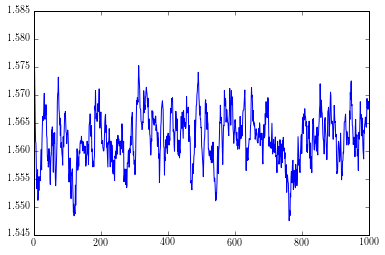

In [373]:
plt.plot(mean_thetas_t)

In [329]:
np.pi/2

1.5707963267948966

In [91]:
np.mean(mean_thetas_t)

1.5680531319864643

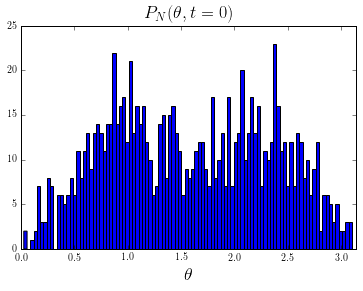

In [374]:
plt.rc('text', usetex=True)
plt.hist(histograma_thetas_t[0], bins=100)
plt.xlabel(r"$\theta$", fontsize = 18)
plt.xlim(0,np.pi)
plt.title(r'$$P_N(\theta,t=0)$$', fontsize = 18)

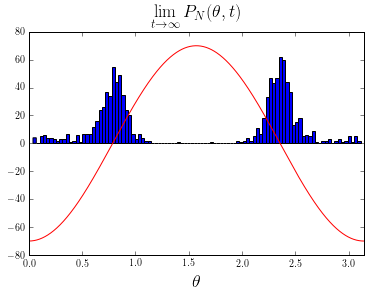

In [377]:
plt.rc('text', usetex = True)
plt.hist(histograma_thetas_t[900], bins=100, color = 'b')
#*abs(np.sin(np.linspace(0,np.pi,1000))**2)
plt.plot(np.linspace(0,np.pi,1000),   -70.0*np.cos(2*#
np.linspace(0,np.pi,1000)), color ="r")
plt.xlabel(r"$\theta$", fontsize = 18)
plt.xlim(0,np.pi)
plt.title(r'$$\lim_{t \to \infty}P_{N}(\theta,t)$$', fontsize = 18)

In [127]:
tiempo = 0
dt = np.log(10)*1e-4
Nt = 5000
tiempos = [tiempo]
for i in range(Nt):
    tiempo = tiempo + dt
    tiempos.append(tiempo)

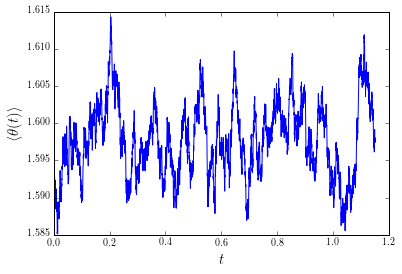

In [130]:
plt.rc('text', usetex=True)
plt.plot(tiempos, mean_thetas_t)
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\langle \theta(t) \rangle$$', fontsize = 15)

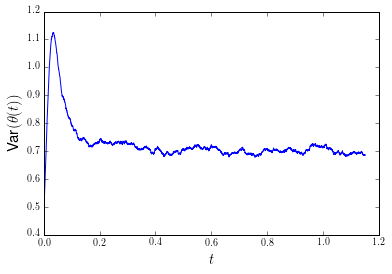

In [133]:
plt.rc('text', usetex=True)
plt.plot(tiempos, var_thetas_t)
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\mbox{Var}(\theta(t))$$', fontsize = 15)

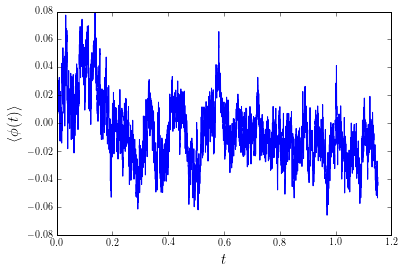

In [132]:
plt.rc('text', usetex=True)
plt.plot(tiempos, mean_phis_t)
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\langle \phi(t) \rangle$$', fontsize = 15)

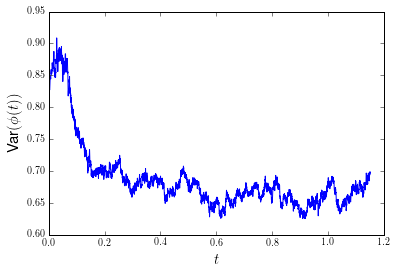

In [134]:
plt.rc('text', usetex=True)
plt.plot(tiempos, var_phis_t)
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\mbox{Var}(\phi(t))$$', fontsize = 15)

# Quadrupole Statistics

In [342]:
#q = (R)*np.tan(s/(R))
def nuevo_r_field(r, vector_q, field):
    nfield = np.tan(field)
    y = r + vector_q + nfield
    y = y/np.linalg.norm(y)
    return y

def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    field = (-v0*np.sin(6*theta)*theta_uni(theta, phi))
    return field

def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))


def act_n_field(lista, v0):
    l = []
    for v in lista:
        s = ese(D,dt)
        l.append(actualiza_field_theta(v, s, v0))
    return l


In [343]:
#Paramtreos de la simulacion
D = 1.
dt = np.log(10)*1e-3
v0 = 10*np.sqrt(2*D)*dt
dist_uni = obs_uniforme(10000, 1., 0)
#dist_uni = polo_n(1000,1.)

Nt = 600


#plot_potential(dist_uni,0,0,0)
rs = dist_uni


#Variables para el analisis estadistico
ht0,mt0,vt0 = mean_var_hist_theta(rs)
hp0,mp0,vp0 = mean_var_hist_phis(rs)
mean_thetas_t = [mt0]
var_thetas_t = [vt0]
mean_phis_t = [mp0]
var_phis_t = [vp0]
histograma_thetas_t = [ht0]
histograma_phis_t = [hp0]



for i in range(Nt):
         
        nuevas_pos = act_n_field(rs, v0)
        #plot_potential(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos
        ht, mt0, vt0 = mean_var_hist_theta(rs)
        hp, mp0, vp0 = mean_var_hist_phis(rs)
        histograma_thetas_t.append(ht)
        histograma_phis_t.append(hp)
        mean_thetas_t.append(mt0)
        var_thetas_t.append(vt0)
        mean_phis_t.append(mp0)
        var_phis_t.append(vp0)
        

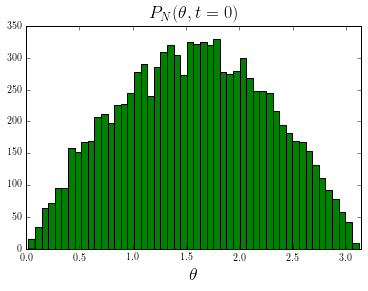

In [344]:
plt.rc('text', usetex=True)
plt.hist(histograma_thetas_t[0], bins=50, color = 'g')
plt.xlabel(r"$\theta$", fontsize = 18)
plt.xlim(0,np.pi)
plt.title(r'$$P_N(\theta,t=0)$$', fontsize = 18)

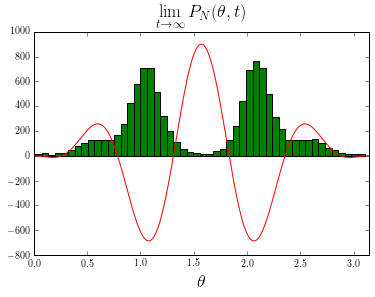

In [345]:
plt.rc('text', usetex = True)
plt.hist(np.array(histograma_thetas_t[-1]), bins=50, color = 'g')
plt.plot(np.linspace(0,np.pi,1000),   -900.*abs(np.sin(np.linspace(0,np.pi,1000))**2)*np.cos(6*#
np.linspace(0,np.pi,1000)), color ="r")
plt.xlabel(r"$\theta$", fontsize = 18)
plt.xlim(0,np.pi)
plt.title(r'$$\lim_{t \to \infty}P_{N}(\theta,t)$$', fontsize = 18)

In [215]:
tiempo = 0
dt = np.log(10)*1e-4
#Nt = 10000
tiempos = [tiempo]
for i in range(Nt):
    tiempo = tiempo + dt
    tiempos.append(tiempo)

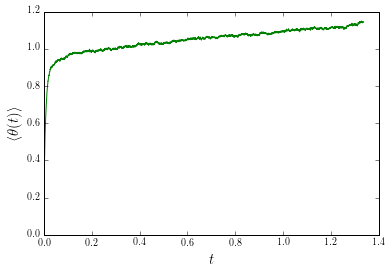

In [218]:
plt.rc('text', usetex=True)
plt.plot(tiempos[:5800], mean_thetas_t[:5800], color = 'g')
#plt.plot(tiempos[:5800], np.arccos(np.exp(-14*D*np.array(tiempos[:5800]))))
#plt.plot(tiempos[:5800], np.pi/2*np.ones(len(tiempos[:5800])), color = 'r')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\langle \theta(t) \rangle$$', fontsize = 15)

(0, 0.55)

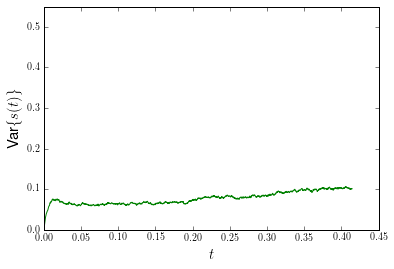

In [219]:
plt.rc('text', usetex=True)
plt.plot(tiempos[:1800], var_thetas_t[:1800], color = 'g')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\mbox{Var}\{s(t)\}$$', fontsize = 15)
plt.ylim(0,.55)

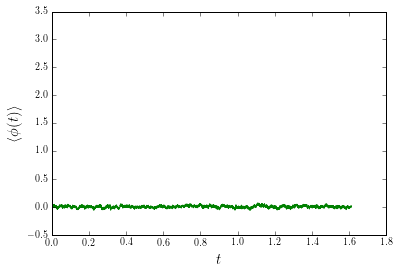

In [220]:
plt.rc('text', usetex=True)
plt.plot(tiempos, mean_phis_t, color = 'g')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\langle \phi(t) \rangle$$', fontsize = 15)

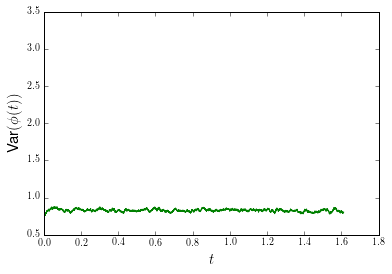

In [221]:
plt.rc('text', usetex=True)
plt.plot(tiempos, var_phis_t, color =  'g')
plt.xlabel(r'$t$', fontsize = 15)
plt.ylabel(r'$$\mbox{Var}(\phi(t))$$', fontsize = 15)

# Gravitational Field Statistics

In [146]:
!pwd

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Potential_Dipole_View_05


In [147]:
%cd ..

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs


In [148]:
!mkdir Gravitational_Field

In [149]:
%cd Gravitational_Field/

/Users/draflorencia/Documents/Adriano/simulaciones/New_Programs/Gravitational_Field


In [150]:
def nuevo_r_field(r, vector_q, field):
    y = r + vector_q + field
    y = y/np.linalg.norm(y)
    return y

def field_theta(ri, v0):
    r, theta, phi = trans_c_s(ri[0],ri[1],ri[2])
    field = (-2*v0*np.sin(1*theta)*theta_uni(theta, phi))
    return field

def actualiza_field_theta(r,s,v0):
    v1, v2 = base_ort_nor(r)
    pre_q = vector_des(v1,v2)
    q = vector_q(pre_q, s)
    return nuevo_r_field(r, q, field_theta(r,v0))


def act_n_field(lista, v0):
    l = []
    for v in lista:
        s = ese(D,dt)
        l.append(actualiza_field_theta(v, s, v0))
    return l


In [151]:
#Paramtreos de la simulacion
D = 1.
dt = np.log(10)*1e-4
v0 = 20*np.sqrt(2*D)*dt
dist_uni = obs_uniforme(1000, 1., 0)
Nt = 5000


#plot_potential(dist_uni,0,0,0)
rs = dist_uni


#Variables para el analisis estadistico
mt0,vt0 = mean_var_theta(rs)
mp0,vp0 = mean_var_phis(rs)
mean_thetas_t = [mt0]
var_thetas_t = [vt0]
mean_phis_t = [mp0]
var_phis_t = [vp0]
histograma_thetas_t = []
histograma_phis_t = []



for i in range(Nt):
         
        nuevas_pos = act_n_field(rs, v0)
        #plot_potential(nuevas_pos, 0, 0, i + 1)
        rs = nuevas_pos
        ht, mt0, vt0 = mean_var_hist_theta(rs)
        hp, mp0, vp0 = mean_var_hist_phis(rs)
        histograma_thetas_t.append(ht)
        histograma_phis_t.append(hp)
        mean_thetas_t.append(mt0)
        var_thetas_t.append(vt0)
        mean_phis_t.append(mp0)
        var_phis_t.append(vp0)
        

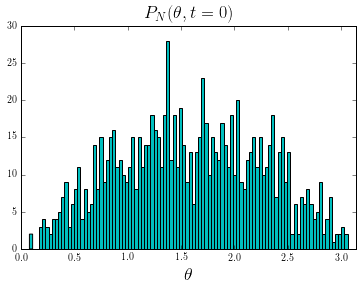

In [155]:
plt.rc('text', usetex=True)
plt.hist(histograma_thetas_t[1], bins=100, color = 'c')
plt.xlabel(r"$\theta$", fontsize = 18)
plt.xlim(0,np.pi)
plt.title(r'$$P_N(\theta,t=0)$$', fontsize = 18)

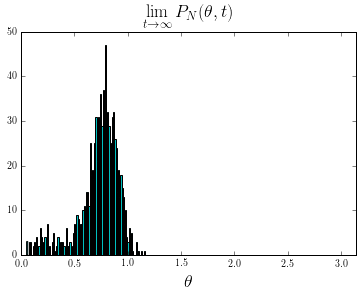

In [156]:
plt.rc('text', usetex = True)
plt.hist(histograma_thetas_t[-1], bins=100, color = 'c')
plt.xlabel(r"$\theta$", fontsize = 18)
plt.xlim(0,np.pi)
plt.title(r'$$\lim_{t \to \infty}P_{N}(\theta,t)$$', fontsize = 18)